# Loading Dataset

In [1]:
from datasets import load_dataset
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

import os
os.environ['HF_HOME'] = '/scratch/tommyvct/cache'
os.environ['TOKENIZERS_PARALLELISM']='true'

/scratch/tommyvct/nlp-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load 10% of the train split (first 10%)
dataset = load_dataset("prithivMLmods/Context-Based-Chat-Summary-Plus", split="train[:1%]")

# Check the size and a sample
print(f"Total examples: {len(dataset)}")  # Should be ~9,840 examples (10% of 98.4K)
print(dataset[0])

Total examples: 984
{'headlines': 'upGrad learner switches to career in ML & Al with 90% salary hike', 'text': "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."}


In [3]:
# 1. Load a Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# 2. Create a list of text data to embed
# texts = [f"{sample['text']} {sample['headline']}" for sample in dataset]
texts = [f"{sample['text']}" for sample in dataset]

# 3. Generate embeddings
embeddings = model.encode(texts)

assert len(texts) == len(embeddings)

In [4]:
random_state = 0

# Elbow Method

In [5]:
k_range = [10, 20, 30, 35, 40, 45, 48, 50, 60, 90, 100, 200]
knee_locators = {}
elbow_n_clusters = {}

for max_k in k_range:
    K = range(2, max_k)
    inertias = []

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_) # Sum of squared distances to the closest centroid

    # pick the K at elbow
    knee_locators[max_k] = KneeLocator(K, inertias, curve="convex", direction="decreasing")
    elbow_n_clusters[max_k] = int(knee_locators[max_k].knee)

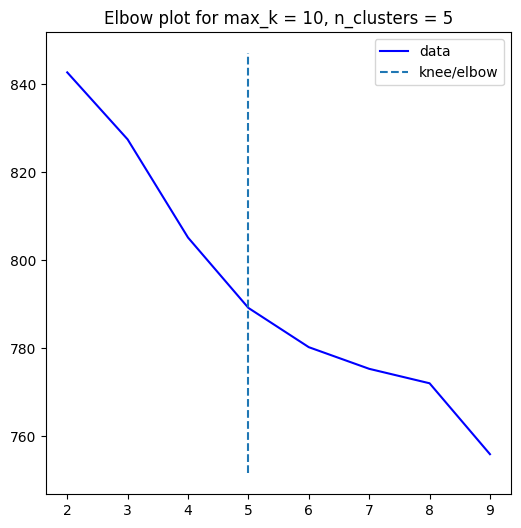

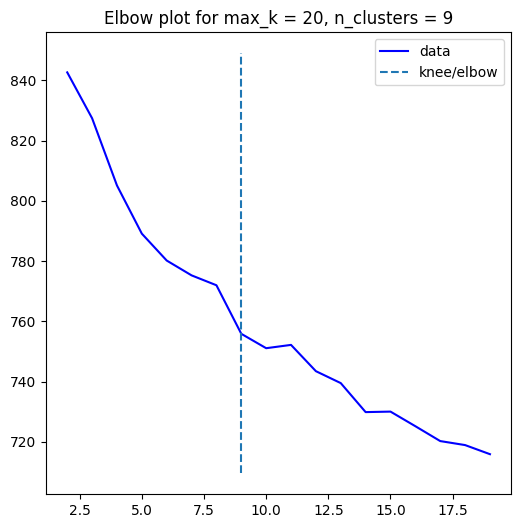

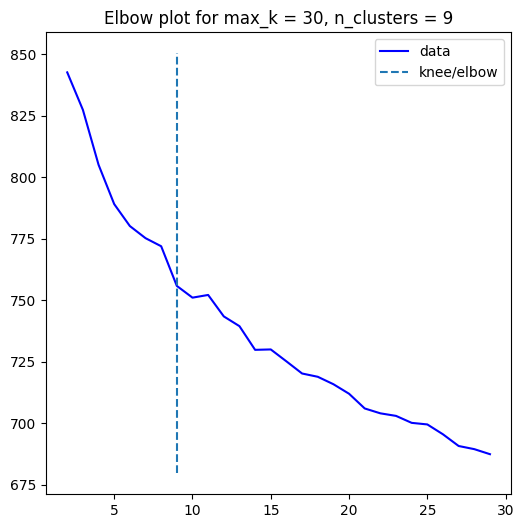

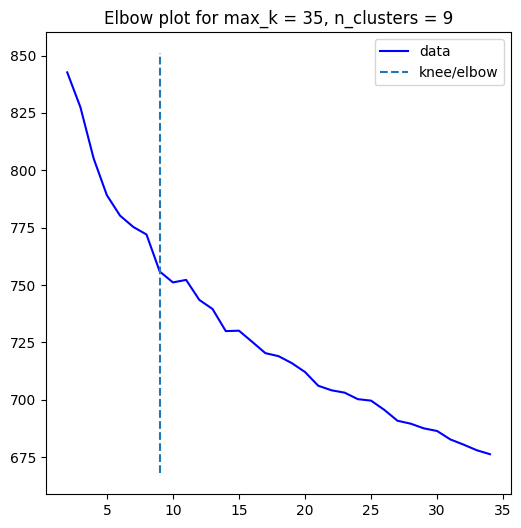

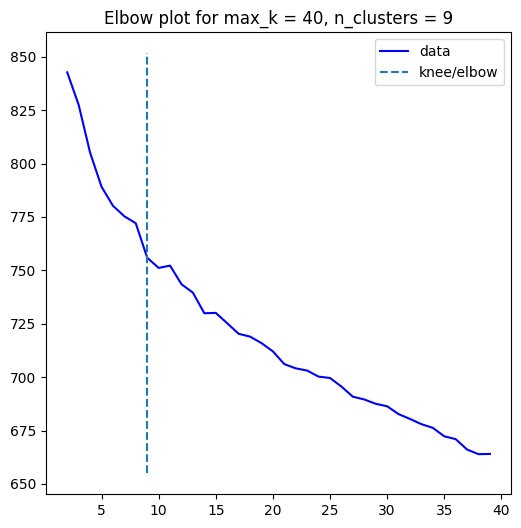

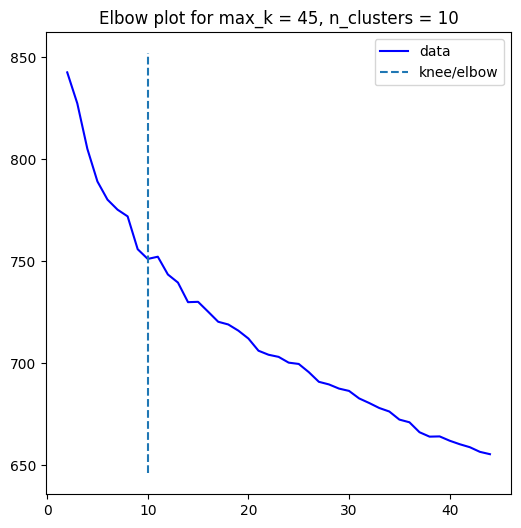

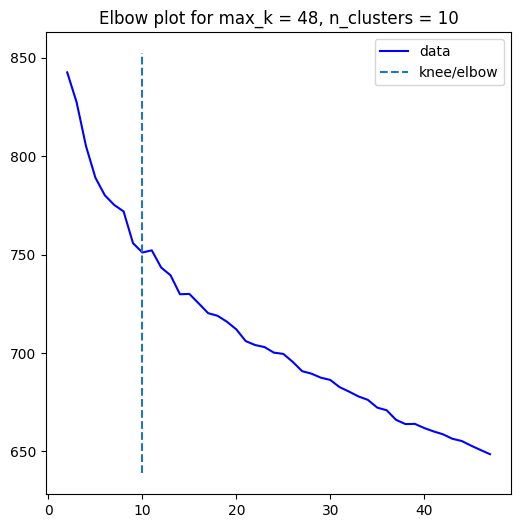

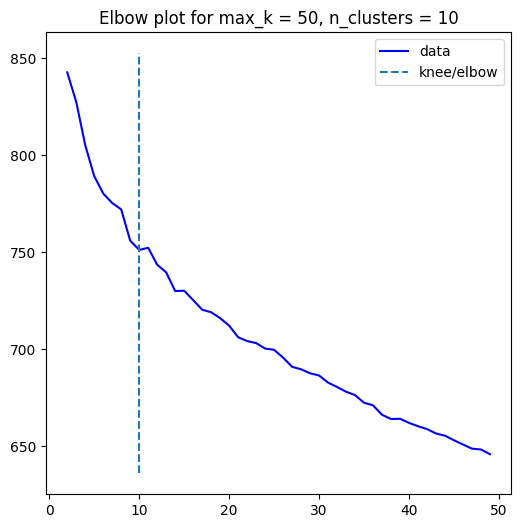

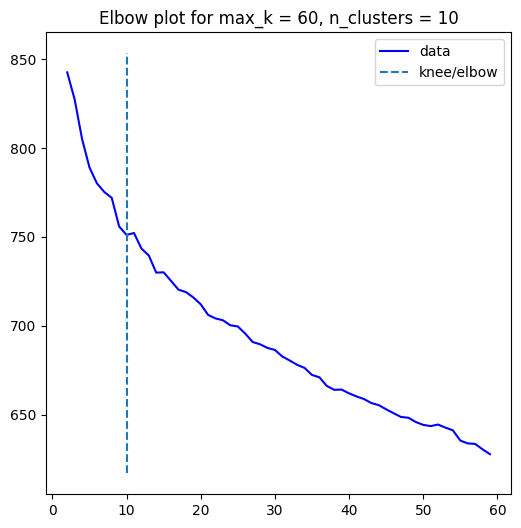

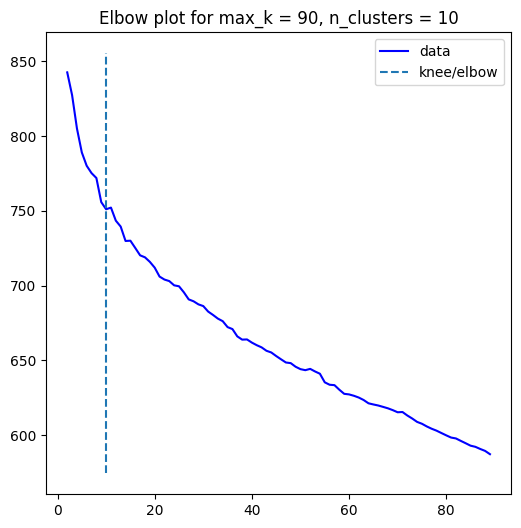

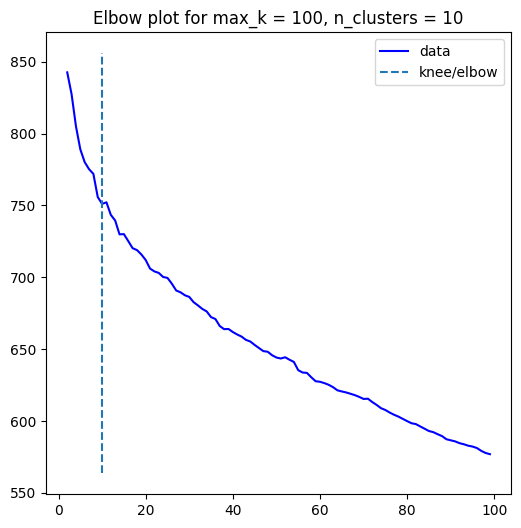

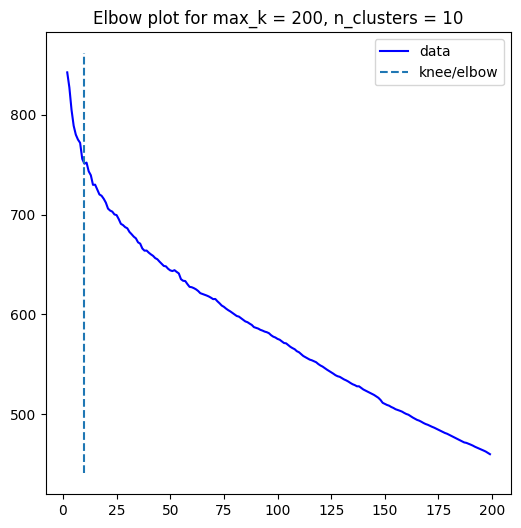

In [6]:
for max_k in k_range:
    # print(f"Best number of clusters for max_k={max_k}: {n_clusters[max_k]}")
    knee_locators[max_k].plot_knee(title=f"Elbow plot for max_k = {max_k}, n_clusters = {elbow_n_clusters[max_k]}")

# Silhouette Method

In [7]:
# Version 2 from Tommy
from joblib import Parallel, delayed

def silhouette_analysis_single(n_clusters, embeddings):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(embeddings)

    labels = kmeans.labels_
    score = silhouette_score(embeddings, labels)
    return score, labels

def silhouette_analysis(range_n_clusters, embeddings):
    def process_cluster(n_clusters):
        score, labels = silhouette_analysis_single(n_clusters, embeddings)
        return {'n_clusters': n_clusters, 'score': score, 'labels': labels}

    silhouette = Parallel(n_jobs=-1)(delayed(process_cluster)(n_clusters) for n_clusters in range_n_clusters)
    silhouette = pd.DataFrame(silhouette)
    return silhouette

def best_k_clusters(silhouette):
    return int(silhouette.loc[silhouette['score'].idxmax()]['n_clusters'])

def plot_silhouette(silhouette):
    plt.figure(figsize=(10, 6))
    plt.plot(silhouette['n_clusters'], silhouette['score'], linestyle='-', color='b')
    
    # Find the number of clusters with the highest silhouette score
    best_cluster = silhouette.loc[silhouette['score'].idxmax()]
    plt.axvline(x=best_cluster['n_clusters'], color='r', linestyle='--', label=f"Best n_clusters = {best_cluster['n_clusters']}, with score = {best_cluster['score']:.6f}")
    
    plt.title(f"Silhouette Score plot for max_k = {max_k}")
    plt.xlabel("Number of Clusters")

    skip = 10 if len(silhouette['n_clusters']) > 60 else 2
    plt.xticks(silhouette['n_clusters'].sort_values()[::skip])
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()

In [8]:
silhouettes = {}
silhouette_n_clusters = {}
for max_k in k_range:
    K = range(2, max_k)
    silhouettes[max_k] = silhouette_analysis(K, embeddings)
    silhouette_n_clusters[max_k] = best_k_clusters(silhouettes[max_k])

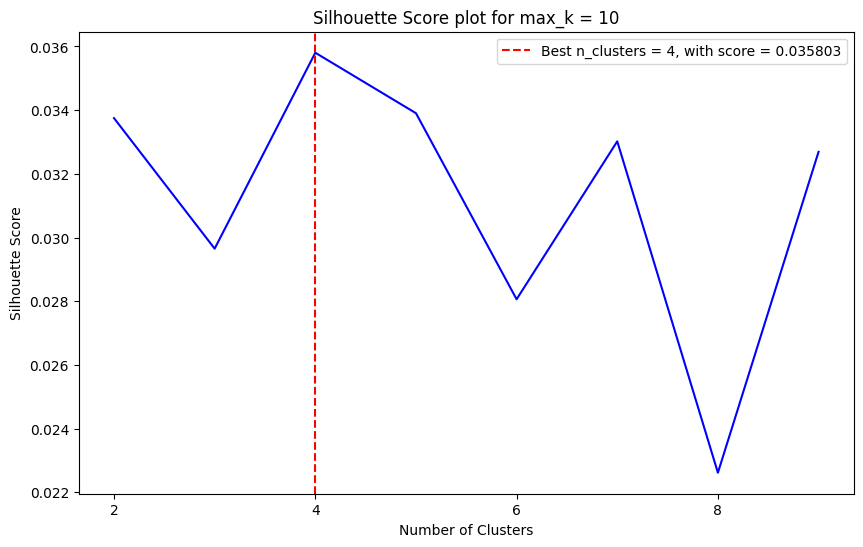

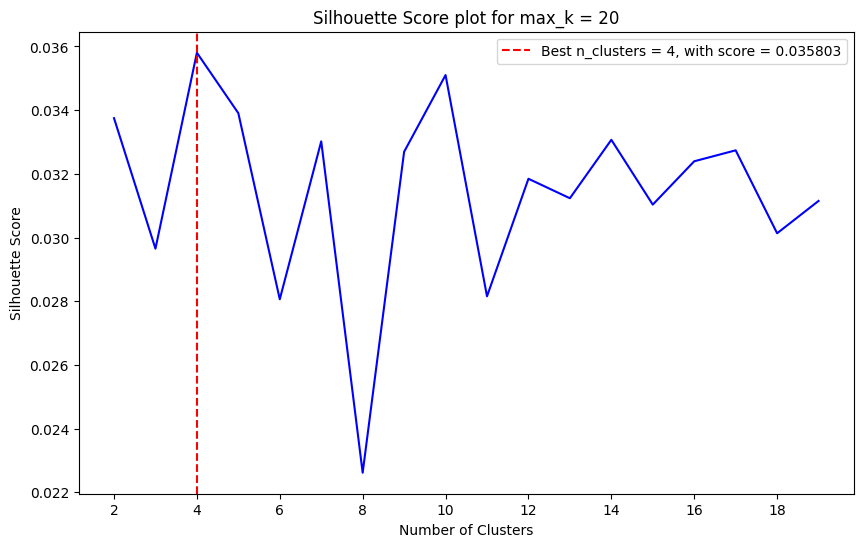

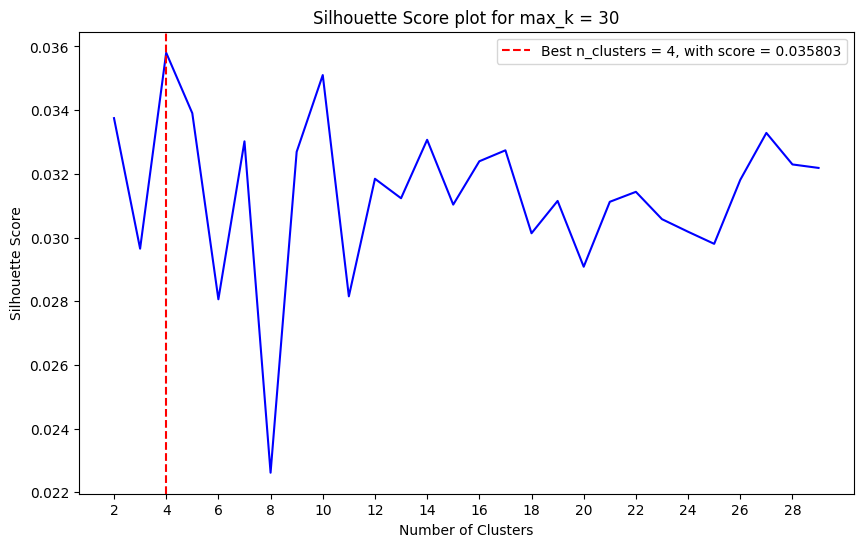

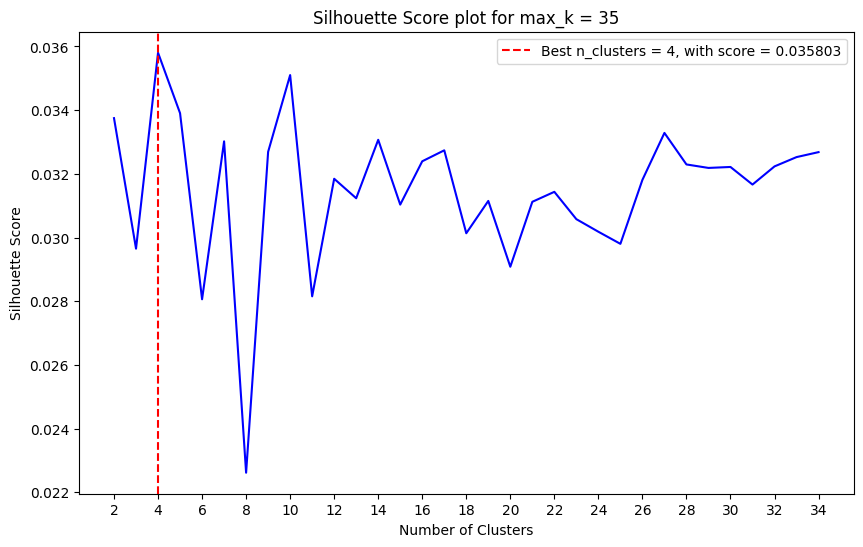

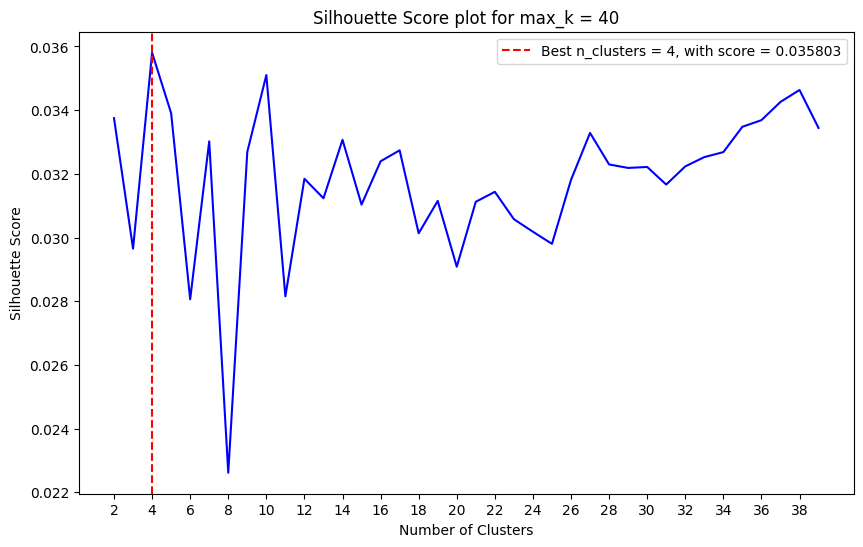

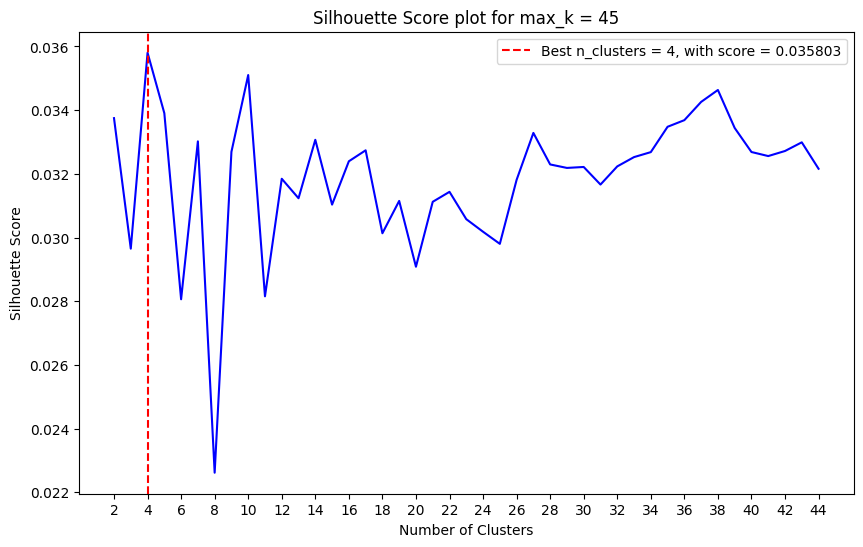

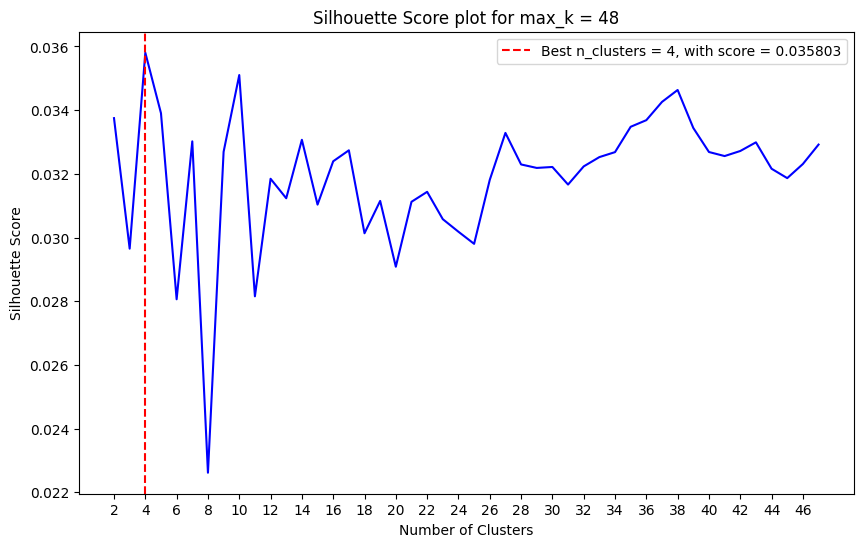

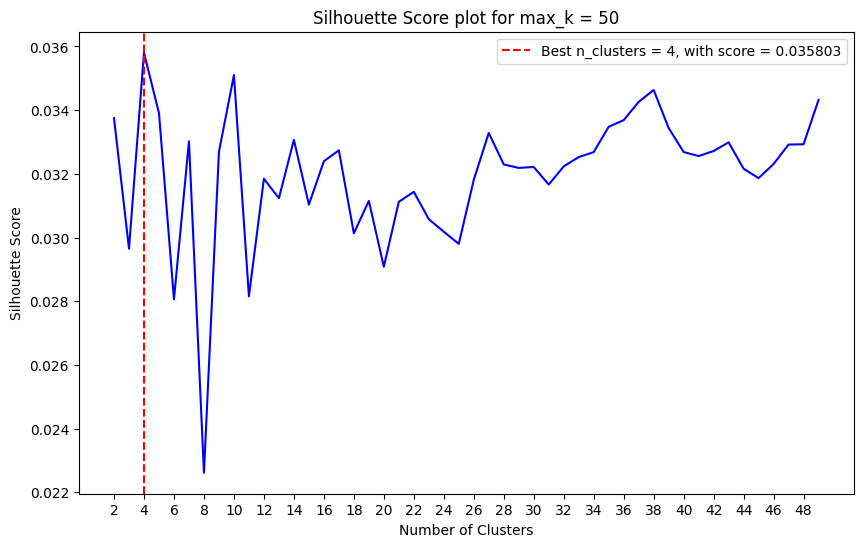

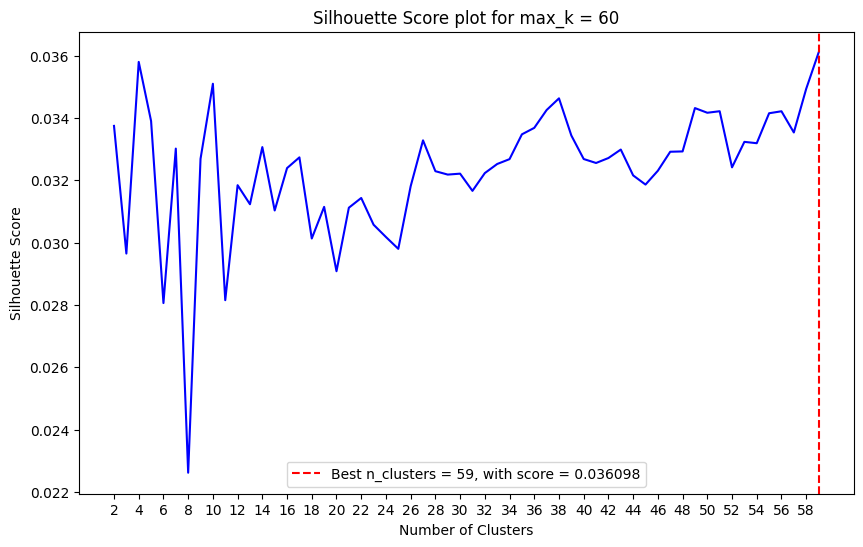

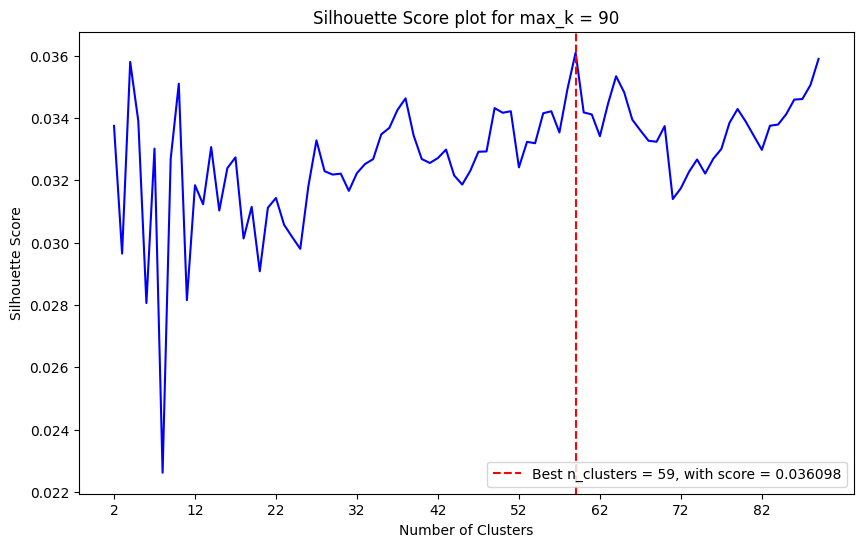

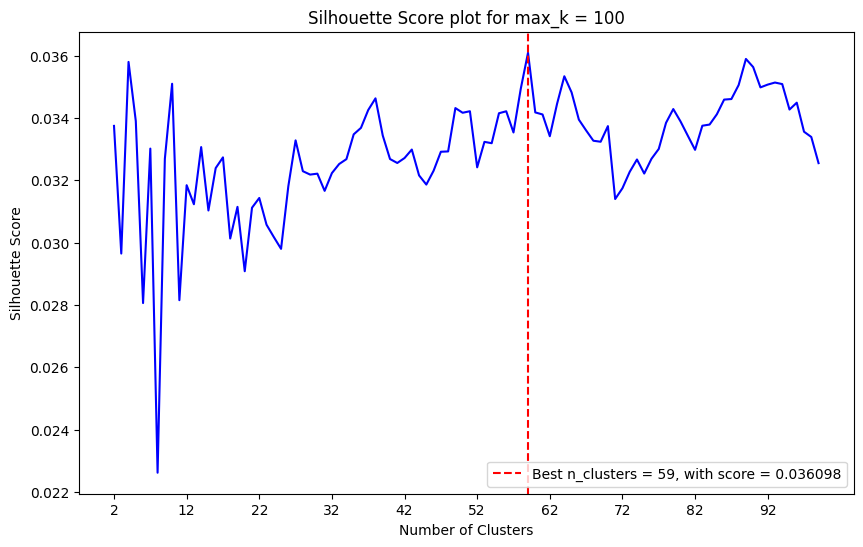

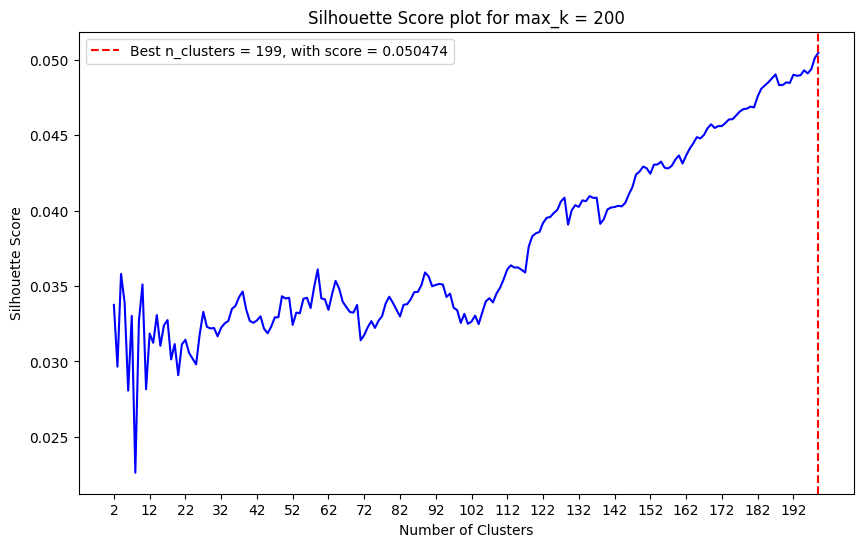

In [9]:
for max_k in k_range:
    plot_silhouette(silhouettes[max_k])

In [10]:
results = pd.DataFrame(list(silhouette_n_clusters.items()), columns=['max_k', 'silhouette_n_clusters'])
results['elbow_n_clusters'] = results['max_k'].map(elbow_n_clusters)
results


,max_k,silhouette_n_clusters,elbow_n_clusters
0,10,4,5
1,20,4,9
2,30,4,9
3,35,4,9
4,40,4,9
5,45,4,10
6,48,4,10
7,50,4,10
8,60,59,10
9,90,59,10
